In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import LineString, Polygon
from shapely.ops import polygonize
from scipy.spatial import Voronoi

np.random.seed(0)
ox.config(use_cache=True)

## Load the data sets

In [2]:
# 2016 demographic data by postcode
path_demographic_data = '../../ABSData/2016 Census GCP Postal Areas for VIC/2016Census_G01_VIC_POA.csv'
postcode_demographics = pd.read_csv(path_demographic_data)
postcode_demographics.shape

(698, 109)

In [3]:
# postcode boundaries shapefile
path_postcode_boundaries = '../../ABSData/Boundaries/POA_2016_AUST.shp'
postcode_boundaries = gpd.read_file(path_postcode_boundaries)
postcode_boundaries.shape

(2670, 5)

In [4]:
# re-project postcode_boundaries to align CRSs
postcode_boundaries = postcode_boundaries.dropna(subset=['geometry']).to_crs(ox.settings.default_crs)

In [5]:
# geocode the addresses of 3 hospitals to lat-lng
dandenong_latlng = ox.geocode('Dandenong Hospital, Dandenong VIC 3175, Australia')
casey_latlng = ox.geocode('62-70 Kangan Dr, Berwick VIC 3806, Australia')
kingston_latlng = ox.geocode('The Kingston Centre, Heatherton VIC 3202, Australia')

# X and Y vectors of these hospitals coordinates
X = [dandenong_latlng[1], casey_latlng[1], kingston_latlng[1]]
Y = [dandenong_latlng[0], casey_latlng[0], kingston_latlng[0]]

## Find postcodes near these hospitals

In [6]:
# merge demographic data with spatial boundaries
gdf = pd.merge(left=postcode_boundaries, right=postcode_demographics,
               how='right', left_on='POA_CODE', right_on='POA_CODE_2016')
gdf.shape

(698, 114)

In [7]:
# extract postcode centroid lats and lngs
postcode_lng = gdf['geometry'].centroid.x
postcode_lat = gdf['geometry'].centroid.y

In [8]:
# calculate great-circle distance from each postcode to each hospital in km
gdf['dist_dandenong'] = ox.great_circle_vec(postcode_lat, postcode_lng, dandenong_latlng[0], dandenong_latlng[1]) / 1000
gdf['dist_casey'] = ox.great_circle_vec(postcode_lat, postcode_lng, casey_latlng[0], casey_latlng[1]) / 1000
gdf['dist_kingston'] = ox.great_circle_vec(postcode_lat, postcode_lng, kingston_latlng[0], kingston_latlng[1]) / 1000

In [9]:
# subset only those postcodes within 10km of any of these 3 hospitals
mask = (gdf['dist_dandenong'] < 10) | (gdf['dist_casey'] < 10) | (gdf['dist_kingston'] < 10)
gdf_nearby = gdf[mask]

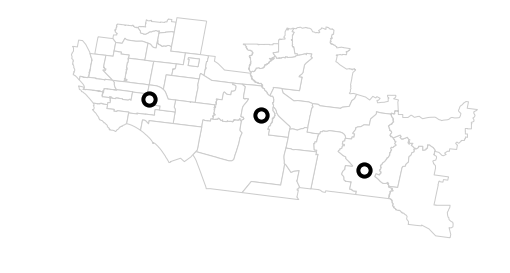

In [10]:
# plot the postcodes and hospitals
fig, ax = plt.subplots(figsize=(8,8))
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1)
ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4)
ax.axis('off')
plt.show()

## Get the street network

In [11]:
# get the street network within the union of these postcodes
polygon = gdf_nearby.unary_union
G = ox.graph_from_polygon(polygon, network_type='drive')

In [12]:
# identify the nearest nodes to each hospital
hospital_nodes = ox.get_nearest_nodes(G, X, Y, method='kdtree')

In [13]:
# sample addresses along the street network
nodes = ox.graph_to_gdfs(G, edges=False).sample(100)

## Identify which addresses are closest to each hospital *along the network*

In [14]:
# calculate network-based distances between each address and each hospital
distances = {}
for node in nodes.index:
    distances[node] = {}
    for hospital_node in hospital_nodes:
        try:
            distance = nx.shortest_path_length(G, source=node, target=hospital_node, weight='length')
        except:
            distance = None
        distances[node][hospital_node] = distance

In [15]:
# identify which hospital is nearest to each address
df_dists = pd.DataFrame(distances).reindex(hospital_nodes).T.dropna().astype(float)
nearest_hospital = df_dists.idxmin(axis=1)

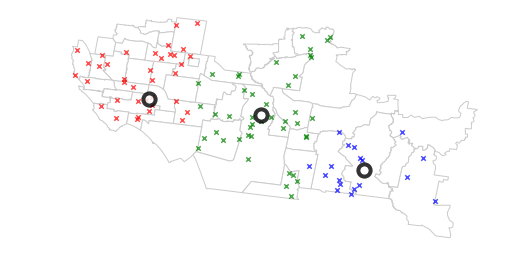

In [16]:
# plot the postcodes, hospitals, and addresses
fig, ax = plt.subplots(figsize=(8,8))
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1, alpha=1)

colors = ['g', 'r', 'b']
groups = nearest_hospital.groupby(nearest_hospital)
for (label, group), c in zip(groups, colors):
    x = nodes.loc[group.index]['x']
    y = nodes.loc[group.index]['y']
    ax.scatter(x, y, marker='x', s=20, color=c, alpha=0.7)

ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4, alpha=0.8)
ax.axis('off')
plt.show()

## Create catchment basins

In [17]:
# create voronoi tessellation
vor = Voronoi(nodes[['x', 'y']])

In [18]:
# convert tessellation into regions
lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
regions = gpd.GeoDataFrame(data=polygonize(lines), columns=['geometry'], geometry='geometry')

In [19]:
# convert regions into temporary catchment basins
basins = []

# for each group of addresses nearest to each hospital
groups = nearest_hospital.groupby(nearest_hospital)
for label, group in groups:
    
    # find all the regions that intersect their point geometries to construct a basin
    points = nodes.loc[group.index]['geometry'].unary_union
    basin = regions[regions.intersects(points)].unary_union
    
    # trim the basin to the extent of the postcodes' geometries
    basin = basin.intersection(gdf_nearby.unary_union)
    basins.append(basin)

gdf_temp_basins = gpd.GeoDataFrame(data=basins, columns=['geometry'], geometry='geometry')

In [20]:
# now expand the catchment basins to fill the postcodes, as tessellation alone likely won't do it
gdf_basins = gdf_temp_basins.copy()
for label in gdf_basins.index:
    
    # get this basin's geometry and the geometry of all other basins
    basin = gdf_basins.loc[label]['geometry']
    others = [l for l in gdf_basins.index if l != label]
    others_geometry = gdf_basins.loc[others, 'geometry'].unary_union
    
    # find all postcodes that intersect this basin, take union, then subtract all other basins from union
    # this expands the basin to fill the postcodes that it touches, without overlapping the other basins
    expanded_basin = gdf_nearby[gdf_nearby.intersects(basin)].unary_union.difference(others_geometry)
    
    # if the difference operation yielded a multipolygon, just take the largest polygon as the basin
    if not isinstance(expanded_basin, Polygon):
        expanded_basin = max(expanded_basin, key=lambda x: x.area)
    
    # add this basin to the geodataframe
    gdf_basins.loc[label] = expanded_basin

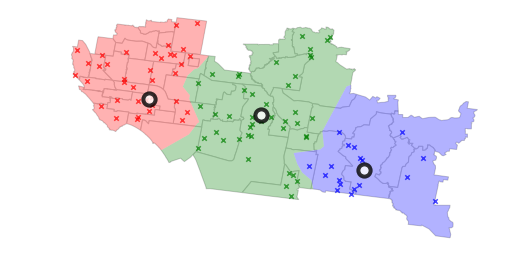

In [21]:
# plot the postcodes, hospitals, addresses, and catchment basins
fig, ax = plt.subplots(figsize=(8,8))

colors = ['g', 'r', 'b']
gdf_nearby.plot(ax=ax, color='w', edgecolor='#cccccc', linewidth=1, alpha=1)
gdf_basins.plot(ax=ax, color=colors, alpha=0.3)

groups = nearest_hospital.groupby(nearest_hospital)
for (label, group), c in zip(groups, colors):
    x = nodes.loc[group.index]['x']
    y = nodes.loc[group.index]['y']
    ax.scatter(x, y, marker='x', s=20, color=c, alpha=0.7)

ax.scatter(X, Y, s=150, c='w', edgecolor='k', linewidth=4, alpha=0.8)
ax.axis('off')
plt.show()

## Estimate cases per hospital